In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

from generation.config import SIGNAL_SIZE, DETECTORS
from generation.dataset.data_utils import get_detector_training_data

In [2]:
# !pip install -e ../../

In [3]:
class SignalsDataset(Dataset):
    def __init__(self, detectors=DETECTORS, signal_size=SIGNAL_SIZE):
        self.detectors = detectors
        self.signal_size = signal_size
        self.signals = self._get_signals()
        self.noises = self._get_noises()
#         noises = self.signals - np.mean(self.signals, axis=0)
#         self.noises = self.scaler.fit_transform(noises)

    def __len__(self):
        return self.noises.shape[1]

    def __getitem__(self, idx):
        noise_tensor = torch.from_numpy(self.noises[:, idx])
        return noise_tensor.float()

    def _get_signals(self):
        signals = []
        for detector in self.detectors:
            signals.append(get_detector_training_data(detector))
        
        signals = np.array(signals)[:, :, :self.signal_size]
        max_amplitudes = np.max(signals, axis=(1, 2))
        signals = signals / max_amplitudes[:, None, None]
        return signals[:, :, :self.signal_size]
    
    def _get_noises(self):
        mean_signals = np.mean(self.signals, axis=1)
        noises = self.signals - mean_signals[:, None, :]
        return noises

In [4]:
dataset = SignalsDataset(signal_size=1024)
signals = dataset.signals
noises = dataset.noises
mean_signals = np.mean(signals, axis=1)

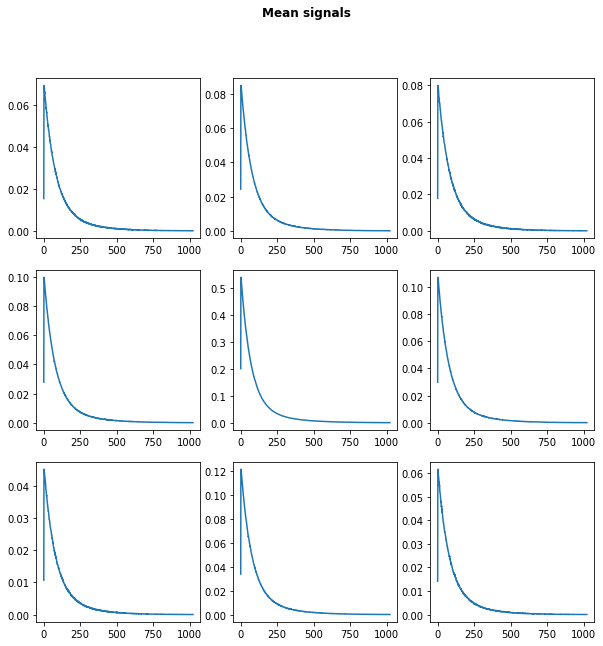

In [5]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))

plt.suptitle("Mean signals", weight='bold')
for i in range(9):
    ax[i // 3][i % 3].plot(mean_signals[i])
plt.show()

In [6]:
noises.shape

(9, 9860, 1024)

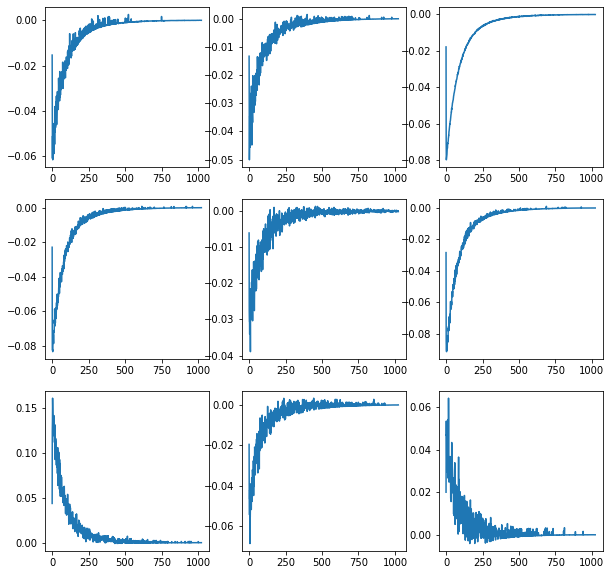

In [7]:
idx = 1301

f, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    ax[i // 3][i % 3].plot(noises[i][idx])
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb


class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.x_dim = config['x_dim']
        self.z_dim = config['z_dim']

        self.fc1 = nn.Linear(self.z_dim, self.x_dim)

        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv1d(8, 32, 3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv1d(64, 16, 3, padding=1)
        self.conv5 = nn.Conv1d(16, 9, 3, padding=1)

        self.batchnorm1 = nn.BatchNorm1d(8)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(16)

    def forward(self, x, debug=False):
        def _debug():
            if debug:
                print(x.shape)

        x = F.leaky_relu(self.fc1(x))
        _debug()
        x = x.unsqueeze(1)
        _debug()
        x = self.conv1(x)
        x = F.leaky_relu(self.batchnorm1(x))
        _debug()
        x = self.conv2(x)
        x = F.leaky_relu(self.batchnorm2(x))
        _debug()
        x = self.conv3(x)
        x = F.leaky_relu(self.batchnorm3(x))
        _debug()
        x = self.conv4(x)
        x = F.leaky_relu(self.batchnorm4(x))
        _debug()
        x = self.conv5(x)
        _debug()

        return x
#         return torch.sigmoid(x.squeeze(1))

    @staticmethod
    def visualize(generated, real, epoch):
        generated_sample = generated[0].cpu().data
        real_sample = real[0].cpu().data

        fig, ax = plt.subplots(3, 3, figsize=(10, 10))
        for i in range(9):
            ax[i // 3][i % 3].plot(generated_sample[i])
        wandb.log({"Generated": fig})
        plt.clf()


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.x_dim = config['x_dim']

        self.fc_final = nn.Linear(288, 1)

        self.pool = nn.AvgPool1d(5, 3)
        self.conv1 = nn.Conv1d(9, 16, 7, padding=3)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv1d(32, 8, 3, padding=1)

        self.layernorm1 = nn.LayerNorm([16, 1024])
        self.layernorm2 = nn.LayerNorm([32, 340])
        self.layernorm3 = nn.LayerNorm([8, 112])

    def forward(self, x, debug=False):
        def _debug():
            if debug:
                print(x.shape)

#         x = x.unsqueeze(1)
#         _debug()
        x = self.conv1(x)
        _debug()
        x = F.leaky_relu(self.layernorm1(x))
        _debug()
        x = self.pool(x)
        _debug()
        x = self.conv2(x)
        x = F.leaky_relu(self.layernorm2(x))
        _debug()
        x = self.pool(x)
        _debug()
        x = self.conv3(x)
        x = F.leaky_relu(self.layernorm3(x))
        _debug()
        x = self.pool(x)
        _debug()
        x = x.view(x.shape[0], -1)

        x = x.squeeze(1)
        _debug()
        x = self.fc_final(x)
        _debug()

        return x


In [9]:
config = {
    "lr": 1e-5,
    "epochs_num": 5000,
    "batch_size": 256,
    "log_each": 1,
    "save_each": 2,
    "device": "cuda:3",
    "x_dim": 1024,
    "z_dim": 8,
    "disc_coef": 5,
    "lambda": 5
}

In [10]:
z = torch.rand(8, 8)

generator = Generator(config)
discriminator = Discriminator(config)

g_sample = generator(z)
discriminator(g_sample)

tensor([[0.1152],
        [0.1558],
        [0.1383],
        [0.1692],
        [0.1660],
        [0.1164],
        [0.0872],
        [0.1790]], grad_fn=<AddmmBackward>)

In [11]:
from generation.training.wgan_trainer import WganTrainer
from generation.training.utils import set_seed

set_seed()

Set seed 42


In [12]:
# alpha = torch.rand((8, 1, 1))
# alpha.expand(g_sample.size())
# (1 - alpha) * g_sample.data

In [ ]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['lr'])
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['lr'])

trainer = WganTrainer(generator, discriminator, g_optimizer, d_optimizer, config)

trainer.run_train(dataset)

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20201018_134717-eq8oiryf
wandb: Syncing run solar-microwave-273


  0%|          | 0/5000 [00:00<?, ?it/s]

  4%|▍         | 202/5000 [35:08<13:50:44, 10.39s/it]